<img src="logounsam.jpg" align="right" width="150">

# TS9 - Filtrado No Lineal
## Alumnas: Catalina Gonzalez Araujo y Lola Pampin
## Docentes: Mariano Llamedo Soria, Francisco Hernan Ledesma y David Ezequiel Benoit
### 2do cuatrimestre 2025

# Introducción

## Línea de base
Se define a la línea de base del ECG (también llamada isoeléctrica) como la línea plana que sirve como referencia para medir las ondas y segmentos de un latido cardíaco. Se utiliza para definir segmentos como el P-R y el S-T. Es muy usual observar distorsiones o desviaciones debido al movimiento del paciente, la respiración o problemas con los electrodos. Esto provoca problemas en la interpretación de la señal. En esta tarea semanal se analizarán técnicas no lineales de estimación/substracción de la señal de movimiento de base b(n).
$$
\hat{x} = s - \hat{b}
$$
Siendo *s* la señal de ECG registrada con interferencias, y $\hat{x}$ la señal filtrada, una estimación del ECG sin interferencias.

## Filtrado no lineal
El **filtrado no lineal** de señales, una técnica que se distingue por aplicar transformaciones no lineales. Permite abordar distorsiones complejas, eliminar ciertos tipos de ruido y adaptarse a variaciones en los datos.
Los filtros no lineales no satisfacen los principios de homogeneidad ni superposición, por lo que su salida no es proporcional a la entrada. Además, las operaciones que realizan dependen tanto de los valores como de la disposición de las muestras de entrada. Debido a esta naturaleza, su comportamiento es más irregular y funcionalmente diverso, lo que los hace más difíciles de analizar y modelar.

*Características principales de los filtros no lineales*:
- No cumplen el principio de superposición: la respuesta no es una combinación lineal de las entradas.
- Operaciones complejas: aplican transformaciones dependientes del contexto de los datos.
- Reducción eficaz de ruido: son especialmente útiles para eliminar tipos específicos de ruido.
- Preservación de bordes: mantienen o realzan bordes y detalles finos en imágenes.
- Comportamiento adaptativo: se ajustan mejor a datos heterogéneos y entornos variables.

En este trabajo en particular se utilizará el filtro de mediana, la interpolación mediante splines cúbicos y el filtro adaptado.

### 1. Filtro de mediana
Se estima $\hat{b}$ a partir de la siguiente expresión:

$$
\hat{b} = \operatorname{med}_{600} \Big( \operatorname{med}_{200}(s) \Big)
$$

siendo $\operatorname{med}_{t}(s)$ el operador de mediana de $t$ milisegundos que se aplica sobre la señal $s$, es decir:

$$
\hat{b} = \operatorname{med}\big(m[n], m[n-1], \dots, m[n - 600 \cdot f_s]\big)
$$

donde

$$
m[n] = \operatorname{med}\big(s[n], s[n-1], \dots, s[n - 200 \cdot f_s]\big)
$$

### 2. Interpolación mediante splines cúbicos

Para corregir la interferencia producida por el movimiento de la línea de base en señales ECG, se estima el nivel isoeléctrico en el intervalo entre las ondas P y Q, donde la actividad eléctrica cardíaca es prácticamente nula. Este intervalo se identifica a partir de las detecciones provistas en ecg.mat (campo qrs_detections) y se define el conjunto:

$$
S = \{ (m_i, s(m_i)) \mid i = 1, 2, \dots, Q \}
$$

donde:
$$
m_i = n_i - n_0
$$

siendo $n_i$ la posición del latido detectado y $n_0$ un desplazamiento que evita incluir las ondas P y Q. El valor Q corresponde a la cantidad total de latidos en el registro (en este caso 1903).

La estimación de la línea de base se obtiene mediante interpolación cúbica:

$$
\hat{b}(n) = \text{spline}_3(S, n) \quad \text{para } n = 1, 2, \dots, N
$$

donde $\text{spline}_3$ es la función que realiza la interpolación para las N muestras de la señal original s(n). Este método garantiza continuidad en la primera y segunda derivada, proporcionando una aproximación suave y estable del desplazamiento de la línea de base.

### 3. Filtro adaptado (matched filter)

"En procesamiento de señales, la salida del filtro adaptado se obtiene correlacionando una señal conocida y retardada, denominada plantilla, con una señal desconocida, con el objetivo de detectar la presencia de dicha plantilla en la señal analizada. Este procedimiento es equivalente a convolucionar la señal desconocida con una versión conjugada e invertida en el tiempo de la plantilla. El filtro adaptado constituye el filtro lineal óptimo para maximizar la relación señal-ruido (SNR) en presencia de ruido estocástico aditivo."

Dentro de sus ventajas se puede mencionar:
- Máxima relación señal-ruido (SNR): Es el filtro lineal óptimo para detectar señales en presencia de ruido aditivo estocástico.
- Alta sensibilidad: Permite detectar señales débiles que se encuentran sumergidas en ruido.
- Aplicabilidad en múltiples dominios: Se utiliza en radar, comunicaciones, procesamiento de imágenes, sismología y astronomía.
- Robustez frente a ruido blanco: Su diseño está optimizado para entornos donde el ruido es gaussiano y aditivo.
- Facilidad de implementación digital: Puede implementarse mediante correlación o convolución, lo que lo hace compatible con sistemas digitales.


Respecto a las desventajas:

- Dependencia de la señal conocida: Requiere conocer la forma exacta de la señal o plantilla para diseñar el filtro.
- Sensibilidad a errores de sincronización: Un desfase temporal entre la señal recibida y la plantilla reduce significativamente el rendimiento.
- Alto costo computacional: La correlación o convolución con señales largas puede ser costosa en tiempo y recursos.
- No óptimo ante ruido no gaussiano: Su desempeño se degrada si el ruido no cumple las condiciones asumidas (ruido blanco gaussiano).
- Vulnerabilidad a interferencias: Si existen señales similares a la plantilla, puede producir falsas detecciones.

# Desarrollo


In [25]:
# INCLUDES

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio
import matplotlib.patches as patches
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks

In [26]:
# TS8 --> lo necesario de la ts anterior

# %% 1) PLANTILLA DE DISEÑO - PASABANDA DIGITAL

fs = 1000  # [Hz]
wp = (0.8, 35)
ws = (0.1, 40)

# Atenuaciones (divididas entre 2 porque se filtra forward + backward)
alpha_p = 0.5     # dB
alpha_s = 20      # dB


# %% 2) DISEÑO IIR (BUTTER - CHEBY1 - CHEBY2 - CAUER)

mi_sos_butt  = signal.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s, ftype='butter', fs=fs, output='sos')

mi_sos_cauer = signal.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s, ftype='ellip', fs=fs, output='sos')

mi_sos_cheb1 = signal.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s, ftype='cheby1', fs=fs, output='sos')

# mi_sos_cheb2 = sig.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s, ftype='cheby2', fs=fs, output='sos')

# Elegimos dos para graficar
mi_sos1 = mi_sos_cauer
tipo1 = "Cauer"

mi_sos2 = mi_sos_cheb1
tipo2 = "Cheby 1"

# Respuesta en frecuenia (uso sosfreqz)
w1, h1 = signal.sosfreqz(mi_sos1, worN=2048, fs=fs)
w2, h2 = signal.sosfreqz(mi_sos2, worN=2048, fs=fs)

# Fase
fase1 = np.unwrap(np.angle(h1))
w_rad1 = w1 / (fs/2) * np.pi
gd1 = -np.diff(fase1) / np.diff(w_rad1)

fase2 = np.unwrap(np.angle(h2))
w_rad2 = w2 / (fs/2) * np.pi
gd2 = -np.diff(fase2) / np.diff(w_rad2)

# %% 2) DISEÑO FIR (FIRWIN2 y FIRLS)

frecuencias = np.array([0, 0.1, 0.8, 35, 35.7, fs/2])
deseado     = np.array([0, 0, 1, 1, 0, 0])

# FIR con ventana rectangular
numtaps = 1001
fir_win = signal.firwin2(numtaps, frecuencias, deseado, fs=fs, window='boxcar')
retardo = (numtaps - 1)//2

# FIR Least-Squares
numtaps_ls = 2001  # impar
fir_ls = signal.firls(numtaps_ls, frecuencias, deseado, fs=fs)
retardo_ls = (numtaps_ls - 1)//2

# Respuesta en frecuencia
w_fir, h_fir = signal.freqz(fir_win, worN=2048, fs=fs)
fase_fir = np.unwrap(np.angle(h_fir))
gd_fir = -np.diff(fase_fir) / np.diff(w_fir/fs*np.pi)

w_ls, h_ls = signal.freqz(fir_ls, worN=2048, fs=fs)
fase_ls = np.unwrap(np.angle(h_ls))
gd_ls = -np.diff(fase_ls) / np.diff(w_ls/fs*np.pi)

# %% CARGO EL ECG REAL

mat = sio.loadmat('./ecg.mat')
ecg_raw = mat['ecg_lead'].flatten()
N = len(ecg_raw)

# ---- Filtrado ----
ecg_filt_iir = signal.sosfiltfilt(mi_sos_butt, ecg_raw)
ecg_filt_fir = signal.filtfilt(fir_win, 1, ecg_raw)

# %% GRAFICOS — ZONAS SIN RUIDO

regiones_sin_ruido = [
    [4000, 5500],
    [10000, 11000]
]

# %% GRAFICOS — ZONAS CON RUIDO

regiones_ruidosas = [
    (np.array([5, 5.2])*60*fs).astype(int),
    (np.array([12, 12.4])*60*fs).astype(int),
    (np.array([15, 15.2])*60*fs).astype(int)
]

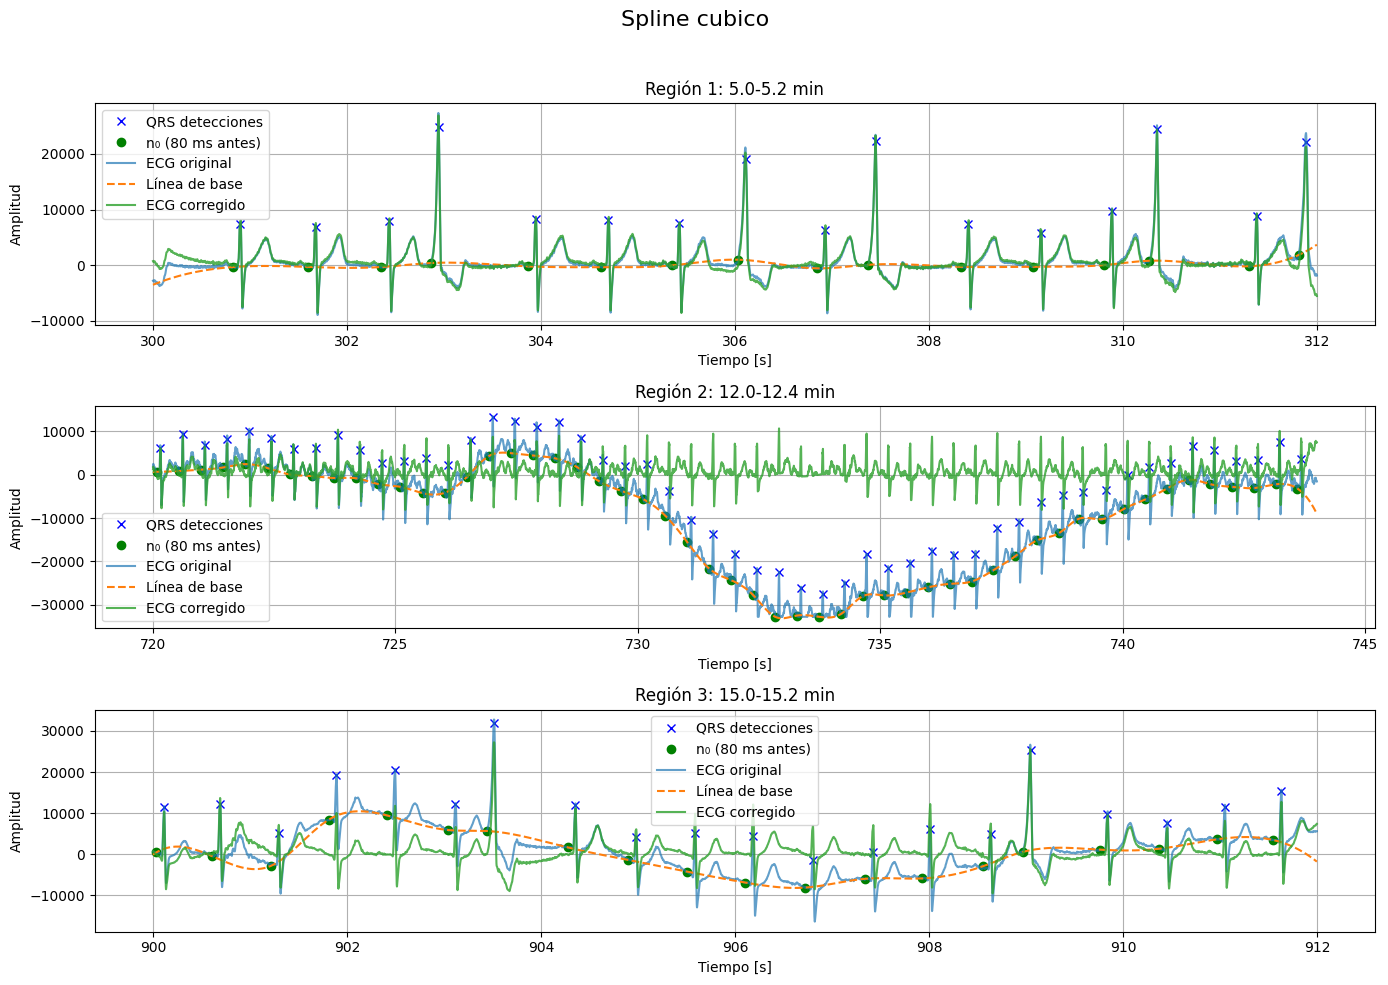

C:\Users\lolyy\AppData\Local\Temp\ipykernel_11836\266349048.py:108: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\lolyy\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


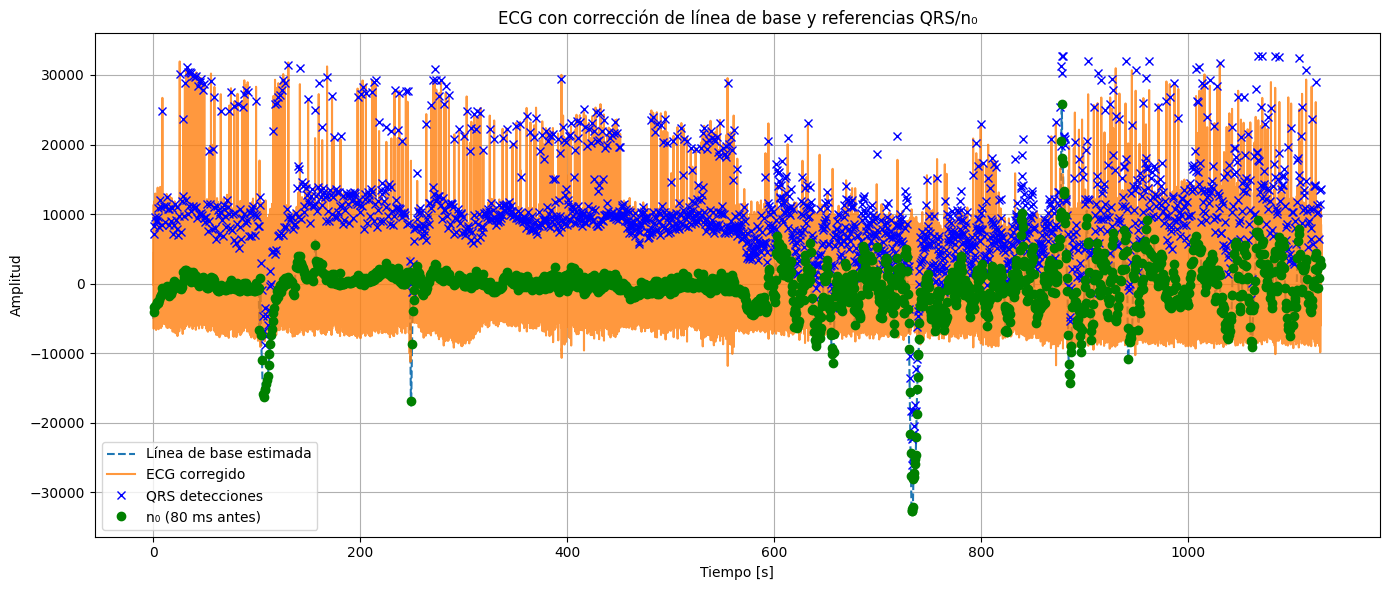

In [27]:
# %% TS9

# Interpolacion --> metodo estimacion sustraccion
qrs_detections = mat['qrs_detections'].flatten()
n0 = int(0.08 * fs)  # 80 ms antes del QRS


# Construir puntos S
m_points = qrs_detections - n0
m_points = m_points[m_points > 0]  # evitar índices negativos
s_values = ecg_raw[m_points] 

# Interpolación spline cúbica
cs = CubicSpline(m_points, s_values)
baseline = cs(np.arange(len(ecg_raw)))

# ECG corregido (remover línea de base)
ecg_corrected = ecg_raw - baseline

# Crear una sola figura con subplots
fig, axes = plt.subplots(len(regiones_ruidosas), 1, figsize=(14, 10), sharex=False)


# Título general para toda la figura
fig.suptitle("Spline cubico", fontsize=16)

for idx, reg in enumerate(regiones_ruidosas):
    start, end = reg.astype(int)
    ecg_region = ecg_raw[start:end]
    t_region = np.arange(start, end) / fs

    # Filtrar QRS en la región
    qrs_region = qrs_detections[(qrs_detections >= start) & (qrs_detections < end)]

    # Construir puntos PQ
    m_points = qrs_region - n0
    m_points = m_points[m_points > start]
    s_values = ecg_raw[m_points]

    # Interpolación spline cúbica
    cs = CubicSpline(m_points, s_values)
    baseline_region = cs(np.arange(start, end))

    # ECG corregido
    ecg_corrected = ecg_region - baseline_region
    
    
    # Agregar cruces verdes en QRS detectados
    axes[idx].plot(t_region[qrs_region - start], ecg_region[qrs_region - start], 'bx', label='QRS detecciones')
    
    axes[idx].plot(t_region[m_points - start], ecg_region[m_points - start], 'go', label='n₀ (80 ms antes)')


    # Graficar en el subplot correspondiente
    axes[idx].plot(t_region, ecg_region, label='ECG original', alpha=0.7)
    axes[idx].plot(t_region, baseline_region, label='Línea de base', linestyle='--')
    axes[idx].plot(t_region, ecg_corrected, label='ECG corregido', alpha=0.8)
    axes[idx].set_title(f'Región {idx+1}: {start/fs/60:.1f}-{end/fs/60:.1f} min')
    axes[idx].set_xlabel('Tiempo [s]')
    axes[idx].set_ylabel('Amplitud')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar para que no tape el título general
plt.show()


# %% Para todo el ecg
qrs_detections = mat['qrs_detections'].flatten()
n0 = int(0.08 * fs)  # 80 ms antes del QRS


# Construir puntos S
m_points = qrs_detections - n0
m_points = m_points[m_points > 0]  # evitar índices negativos
s_values = ecg_raw[m_points] 

# Interpolación spline cúbica
cs = CubicSpline(m_points, s_values)
baseline = cs(np.arange(len(ecg_raw)))

# ECG corregido (remover línea de base)
ecg_corrected = ecg_raw - baseline

# Vector de tiempo
t = np.arange(len(ecg_raw)) / fs

# Graficar
plt.figure(figsize=(14, 6))
#plt.plot(t, ecg_raw, label='ECG original (con ruido)', alpha=0.7)
plt.plot(t, baseline, label='Línea de base estimada', linestyle='--')
plt.plot(t, ecg_corrected, label='ECG corregido', alpha=0.8)

# QRS detections (cruces azules)
plt.plot(t[qrs_detections], ecg_raw[qrs_detections], 'bx', label='QRS detecciones')

# m_points (círculos verdes)
m_points = qrs_detections - n0
m_points = m_points[m_points > 0]  # evitar negativos
plt.plot(t[m_points], ecg_raw[m_points], 'go', label='n₀ (80 ms antes)')

# Configuración
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('ECG con corrección de línea de base y referencias QRS/n₀')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# ============================
# 1. Crear filtro adaptado
# ============================

patron= mat_struct['qrs_pattern1'].flatten()
patron_2 = patron - np.mean(patron) #para tener area neta nula, util para filtrar
# ============================
# 2. Correlación (convolución)
# ============================
ecg_detection = signal.lfilter(b=patron_2, a=1, x=ecg_one_lead)
ecg_detection_abs = np.abs(ecg_detection)
ecg_detection_abs = ecg_detection_abs/np.std(ecg_detection_abs)
# ============================
# 3. Detectar picos con find_peaks
# ============================
threshold = 0.5 * np.max(ecg_detection_abs)  # umbral simple
peaks, properties = find_peaks(ecg_detection_abs, height=threshold, distance=100)

# ============================
# 4. Comparar con ground truth
# ============================
TP = sum([any(abs(p - qrs_detections) <= 20) for p in peaks])
FP = len(peaks) - TP
FN = len(qrs_detections) - TP
sensibilidad = TP / (TP + FN)
# ppv = TP / (TP + FP)

print("Resultados del detector:")
print(f"Número de picos detectados: {len(peaks)}")
# print(f"TP: {TP}, FP: {FP}, FN: {FN}")
# print(f"Sensibilidad: {sensibilidad:.2f}, PPV: {ppv:.2f}")

# ============================
# 5. Graficar resultados
# ============================
plt.figure(figsize=(12, 6))

# Señal ECG con detecciones
plt.subplot(2, 1, 1)
plt.plot(ecg_one_lead, label='ECG')
plt.scatter(qrs_detections, ecg_one_lead[qrs_detections], color='green', label='Ground Truth')
plt.scatter(peaks, ecg_one_lead[peaks], color='red', label='Detectados')
plt.title('Señal ECG con detecciones')
plt.legend()

# Salida del filtro adaptado
plt.subplot(2, 1, 2)
plt.plot(ecg_detection, label='Correlación (Filtro adaptado)')
plt.scatter(peaks, ecg_detection[peaks], color='red', label='Picos detectados')
plt.title('Salida del filtro adaptado')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'mat_struct' is not defined

# Conclusiones